<a href="https://colab.research.google.com/github/Dk-Alpha/Natural-Language-Processing-using-Tensorflow/blob/main/News_Headlines_for_Sarcasm_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import json
import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [2]:
vocab_size = 10000
embedding_dim = 16
max_length = 100
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000


In [9]:
!wget --no-check-certificate \
    https://storage.googleapis.com/learning-datasets/sarcasm.json \
    -O /tmp/sarcasm.json

--2023-06-13 05:21:23--  https://storage.googleapis.com/learning-datasets/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.192.128, 209.85.145.128, 209.85.146.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.192.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.05s   

2023-06-13 05:21:23 (100 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



<h3>Loading Json Dataset


In [11]:
with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []

for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

In [12]:
training_sentences = sentences[0:training_size]
testing_sentences = sentences[training_size:]
training_labels = labels[0:training_size]
testing_labels = labels[training_size:]

In [13]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)

word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

<h3>Converting Training and Testing sentences to Numpy arrays

In [17]:
# Need this block to get it to work with TensorFlow 2.x
import numpy as np
training_padded = np.array(training_padded)
training_labels = np.array(training_labels)
testing_padded = np.array(testing_padded)
testing_labels = np.array(testing_labels)

<h3>Builiding the model

In [18]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(24, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [19]:
model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 100, 16)           160000    
                                                                 
 global_average_pooling1d_1   (None, 16)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_2 (Dense)             (None, 24)                408       
                                                                 
 dense_3 (Dense)             (None, 1)                 25        
                                                                 
Total params: 160,433
Trainable params: 160,433
Non-trainable params: 0
_________________________________________________________________


<h3>Finding the Accuracy for 30 Epoch

In [20]:
num_epochs = 30
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), verbose=2)

Epoch 1/30
625/625 - 5s - loss: 0.6564 - accuracy: 0.5933 - val_loss: 0.5648 - val_accuracy: 0.7192 - 5s/epoch - 8ms/step
Epoch 2/30
625/625 - 3s - loss: 0.4199 - accuracy: 0.8359 - val_loss: 0.3779 - val_accuracy: 0.8457 - 3s/epoch - 5ms/step
Epoch 3/30
625/625 - 4s - loss: 0.2998 - accuracy: 0.8798 - val_loss: 0.3500 - val_accuracy: 0.8545 - 4s/epoch - 7ms/step
Epoch 4/30
625/625 - 3s - loss: 0.2461 - accuracy: 0.9036 - val_loss: 0.3431 - val_accuracy: 0.8574 - 3s/epoch - 4ms/step
Epoch 5/30
625/625 - 3s - loss: 0.2106 - accuracy: 0.9200 - val_loss: 0.3559 - val_accuracy: 0.8502 - 3s/epoch - 4ms/step
Epoch 6/30
625/625 - 3s - loss: 0.1845 - accuracy: 0.9298 - val_loss: 0.3596 - val_accuracy: 0.8544 - 3s/epoch - 4ms/step
Epoch 7/30
625/625 - 4s - loss: 0.1602 - accuracy: 0.9414 - val_loss: 0.3872 - val_accuracy: 0.8477 - 4s/epoch - 7ms/step
Epoch 8/30
625/625 - 3s - loss: 0.1437 - accuracy: 0.9480 - val_loss: 0.4219 - val_accuracy: 0.8410 - 3s/epoch - 4ms/step
Epoch 9/30
625/625 - 3s 

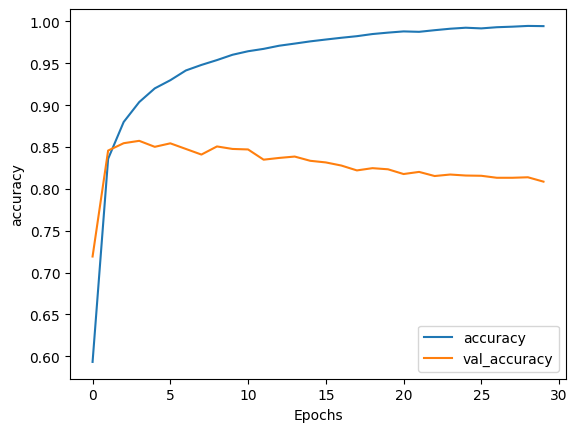

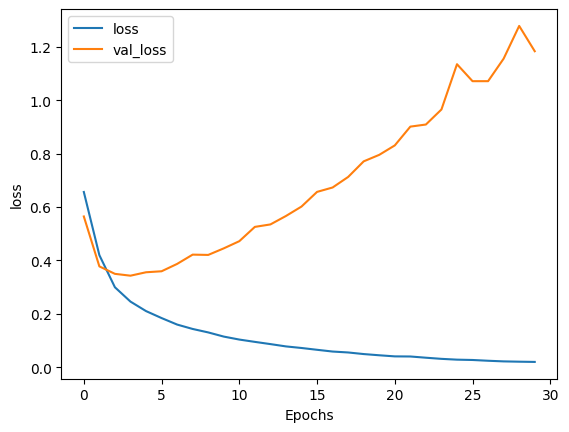

In [21]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()

plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [22]:
e = model.layers[0]
weights = e.get_weights()[0]
print(weights.shape) # shape: (vocab_size, embedding_dim)


(10000, 16)


<h3>Checking sentiment of a particular sentence</h3>

In [23]:
sentence = ["granny starting to fear spiders in the garden might be real", "game of thrones season finale showing this sunday night"]
sequences = tokenizer.texts_to_sequences(sentence)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)
print(model.predict(padded))

1/1 [==============================] - 0s 94ms/step
[[9.6183574e-01]
 [1.7817154e-06]]
